# Stochastic gradient descent

In [35]:
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt

The goal of this practical session is to build a linear classifier that recognizes handwritten digits. In particular, we train the classifier using gradient descent (GD) and stochastic gradient descent (SGD) to minimize the empirical risk.

#### Importation of the data

In [36]:
data = sio.loadmat('mnist_digits.mat')

In [37]:
data_x = data['x'] 
data_y = data['y']
print(data_x.shape, data_y.shape)

(66000, 784) (66000, 1)


#### Example of a random data point

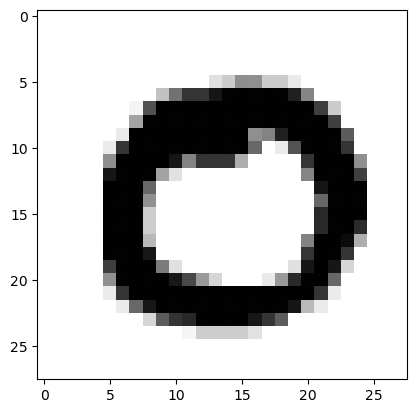

This digit is labeled as a 0.


In [38]:
i = np.random.randint(len(data['x']))
plt.imshow(np.reshape(data_x[i],(28,28)), cmap='binary')
plt.show()
print("This digit is labeled as a {}.".format(int(data_y[i,0])))

In [39]:
data_y2 = data_y.reshape((data_y.shape[0],))

For simplicity, we build a classifier that only distinguishes the digit $6$ from the digit $8$, so that it matches the framework of binary classification.

In [40]:
# select only the 6s and the 8s
indices = np.argwhere((data_y2 == 8) + (data_y2 == 6))[:,0]
x = data_x[indices]
y = data_y2[indices]

In [41]:
# shuffle the data
n = y.shape[0]
perm = np.random.permutation(n)
x2 = x[perm]
y2 = y[perm]

# separate train and test
alpha = 0.1
n_train = int(n*alpha)
n_test = n - n_train
x_train = x2[:n_train] 
x_test = x2[n_train:]
y_train = y2[:n_train]
y_test = y2[n_train:]

# add noise to the data
sigma = 0.1
x_train += sigma*np.random.randn(x_train.shape[0], x_train.shape[1])
x_test += sigma*np.random.randn(x_test.shape[0], x_test.shape[1])

In [54]:
print(n_train)

1291


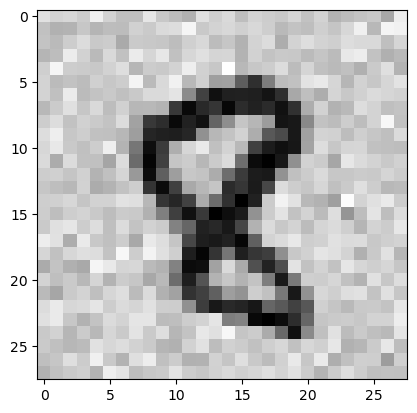

In [42]:
plt.imshow(np.reshape(x_train[0],(28,28)), cmap='binary')
plt.show()

In [43]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1291, 784) (11627, 784) (1291,) (11627,)


In this dataset, the images are represented by vectors $x$ of length $28\times28$ of the grayscale values of the pixels. In this practical session, we will fit classifiers that are linear functions $x \mapsto \theta^Tx$ of the image represented as a vector. 

Note that it is in general a poor choice to use linear functions to classify images. Moreover, one would in general preprocess the images (e.g. through a wavelet transform) in order to obtain a sparser representation. However, as the classification problem that we are interested in is rather simple, it will work in this situation. 

More explicitely, we write $\mathcal{X} = \mathbb{R}^{28\times28}$ the set of images. As we want to consider linear functions, we won't seek a classifier $f:\mathcal{X} \to \{6,8\}$ but a function $f:\mathcal{X} \to \mathbb{R}$; the associated classifier is $6\mathbb{1}_{\{f(x) \leq 7\}} + 8\mathbb{1}_{\{f(x) > 7\}}$.

Our goal is to find a linear (affine) classifier $f:\mathcal{X}\mapsto \mathbb{R}$ that minimizes the 01 risk:
\begin{equation*}
R_{01}(f) = \mathbb{P}\left((Y-7)(f(X)-7) \leq 0\right) \, .
\end{equation*}
In order to do so, we approximate the problem by minimizing the quadratic (convex) empirical risk on the training samples:
\begin{equation*}
R_{\rm train}(f) = \frac{1}{2n_{\rm train}} \sum_{(x_i,y_i) \text{ training samples}} (y_i - f(x_i))^2 \, .  
\end{equation*}
The performance of the resulting classifiers is estimated using the empirical risk on the test samples:
\begin{equation*}
R_{\rm test}(f) = \frac{1}{2n_{\rm test}} \sum_{(x_i,y_i) \text{ test samples}} (y_i - f(x_i))^2 \, .  
\end{equation*}

$\textbf{(1)}$ Implement the gradient descent and the stochastic gradient descent methods with constant stepsizes in order to minimize the empirical risk. 

$\textbf{(2)}$ Compare the two optimisation procedures by plotting the evolution of the empirical risks $R_{\rm train}$ and $R_{\rm test}$ on the training and test samples, as a function **of the number of reads of the samples**. Thus the plot should show 4 curves. This means that one step of GD corresponds to $n_{\rm train}$ reads of the samples, while one step of SGD corresponds to only the read of only one sample. In practice, the number of reads of the data is a good approximation of the computation time. 

Remark: in order to keep the computation time small, I recommend that you do not compute the train and test errors at each step of SGD but only every $T_{\rm period}$ steps  with $T_{\rm period} >> 1$.

#### Adding the intercept

In [44]:
X_train = np.ones((x_train.shape[0],x_train.shape[1]+1))
X_train[:,1:] = x_train
X_test = np.ones((x_test.shape[0],x_test.shape[1]+1))
X_test[:,1:] = x_test

### Loss functions

In [45]:
def emp_risk(theta):
    return np.linalg.norm(y_train-X_train@theta)**2/(2*n_train)

def test_risk(theta):
    return np.linalg.norm(y_test-X_test@theta)**2/(2*n_test)

def zeroone_emp_risk(theta):
    return sum((y_train >= 7) != (X_train@theta >= 7))/len(y_train)

def zeroone_test_risk(theta):
    return sum((y_test >= 7) != (X_test@theta >= 7))/len(y_test)

#### Gradient descent

In [46]:
def grad_emp_risk(theta):
    return -X_train.T@(y_train-X_train@theta)/n_train

In [47]:
T_gd = 30
emp_risks_gd = np.zeros(T_gd)
test_risks_gd = np.zeros(T_gd)
zeroone_emp_risks_gd = np.zeros(T_gd)
zeroone_test_risks_gd = np.zeros(T_gd)
theta = np.zeros(X_train.shape[1])
theta[0] = 7
gamma = 4*10**(-2)
for t in range(T_gd):
    emp_risks_gd[t] = emp_risk(theta)
    test_risks_gd[t] = test_risk(theta)
    zeroone_emp_risks_gd[t] = zeroone_emp_risk(theta)
    zeroone_test_risks_gd[t] = zeroone_test_risk(theta)
    theta -= gamma*grad_emp_risk(theta)

#### Stochastic gradient descent 

In [48]:
def grad_sto(theta,i):
    return -(y_train[i%n_train]-X_train[i%n_train]@theta)*X_train[i%n_train]

In [49]:
T_sgd = T_gd*n_train
T_test_period = 100
emp_risks_sgd = np.zeros(int(T_sgd/T_test_period)+1)
test_risks_sgd = np.zeros(int(T_sgd/T_test_period)+1)
zeroone_emp_risks_sgd = np.zeros(int(T_sgd/T_test_period)+1)
zeroone_test_risks_sgd = np.zeros(int(T_sgd/T_test_period)+1)
theta = np.zeros(X_train.shape[1])
theta[0] = 7
gamma = 1*10**(-3)
for t in range(T_sgd):
    if t%T_test_period == 0:
        emp_risks_sgd[int(t/T_test_period)] = emp_risk(theta)
        test_risks_sgd[int(t/T_test_period)] = test_risk(theta)    
        zeroone_emp_risks_sgd[int(t/T_test_period)] = zeroone_emp_risk(theta)
        zeroone_test_risks_sgd[int(t/T_test_period)] = zeroone_test_risk(theta)
    theta -= gamma*grad_sto(theta,t)

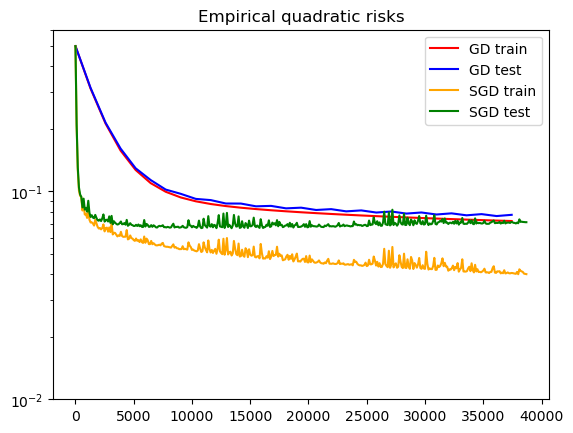

In [53]:
ts_gd = [n_train*t for t in range(T_gd)]
ts_sgd = [t*T_test_period for t in range(int(T_sgd/T_test_period)+1)]
plt.semilogy(ts_gd, emp_risks_gd, 'red', label='GD train')
plt.semilogy(ts_gd, test_risks_gd, 'blue', label='GD test')
plt.semilogy(ts_sgd, emp_risks_sgd, 'orange', label = 'SGD train')
plt.semilogy(ts_sgd, test_risks_sgd, 'green', label = 'SGD test')
plt.legend()
plt.ylim(10**(-2),6*10**(-1))
plt.title('Empirical quadratic risks')
plt.show()

$\textbf{(3)}$ Reproduce the same plot, now showing the empirical train and test 01 losses. 

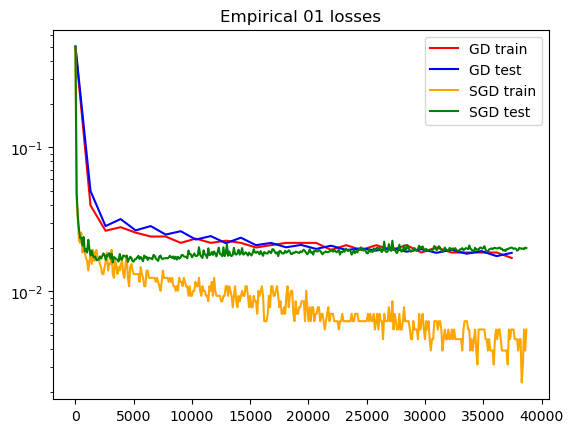

In [51]:
ts_gd = [n_train*t for t in range(T_gd)]
ts_sgd = [t*T_test_period for t in range(int(T_sgd/T_test_period)+1)]
plt.semilogy(ts_gd, zeroone_emp_risks_gd, 'red', label='GD train')
plt.semilogy(ts_gd, zeroone_test_risks_gd, 'blue', label='GD test')
plt.semilogy(ts_sgd, zeroone_emp_risks_sgd, 'orange', label = 'SGD train')
plt.semilogy(ts_sgd, zeroone_test_risks_sgd, 'green', label = 'SGD test')
plt.legend()
plt.title('Empirical 01 losses')
plt.show()